In [2]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold,cross_val_score,train_test_split,cross_val_predict
from sklearn.metrics import r2_score,accuracy_score,precision_score,recall_score
from sklearn.grid_search import GridSearchCV
import seaborn as sns
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [3]:
## Load the data into a DataFrame
dfTrain = pd.read_csv('../assets/train.csv')

dfTrain.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


Var| Description
--|--|--
Id |the id of the record
Date| date that the WNV test is performed
Address| approximate address of the location of trap. This is used to send to the GeoCoder. 
Species| the species of mosquitos
Block| block number of address
Street| street name
Trap| Id of the trap
AddressNumberAndStreet| approximate address returned from GeoCoder
Latitude, Longitude| Latitude and Longitude returned from GeoCoder
AddressAccuracy| accuracy returned from GeoCoder
NumMosquitos| number of mosquitoes caught in this trap
WnvPresent| whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present.

In [4]:
dfTrain.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


In [5]:
dfTrain.info()
dfTrain.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


Date                      False
Address                   False
Species                   False
Block                     False
Street                    False
Trap                      False
AddressNumberAndStreet    False
Latitude                  False
Longitude                 False
AddressAccuracy           False
NumMosquitos              False
WnvPresent                False
dtype: bool

In [6]:
dfWeather = pd.read_csv("../assets/weather.csv")
dfWeather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [7]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing

# Load dataset 
train = pd.read_csv('../assets/train.csv')
sample = pd.read_csv('../assets/sampleSubmission.csv')
weather = pd.read_csv('../assets/weather.csv')

# Get labels
labels = train.WnvPresent.values

# Not using codesum for this benchmark
weather = weather.drop('CodeSum', axis=1)

# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

# Functions to extract month and day from dataset
# You can also use parse_dates of Pandas.
def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

train['month'] = train.Date.apply(create_month)
train['day'] = train.Date.apply(create_day)


# Add integer latitude/longitude columns
train['Lat_int'] = train.Latitude.apply(int)
train['Long_int'] = train.Longitude.apply(int)


# drop address columns

train = train.drop(['Address', 'AddressNumberAndStreet'], axis = 1)

# Merge with weather data
train = train.merge(weather, on='Date')
train = train.drop(['Date'], axis = 1)

# Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)

lbl.fit(list(train['Street'].values) )
train['Street'] = lbl.transform(train['Street'].values)

lbl.fit(list(train['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)

# drop columns with -1s
train = train.ix[:,(train != -1).any(axis=0)]



In [8]:
train.describe()

,Species,Block,Street,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Lat_int,...,Tmax_x,Tmin_x,DewPoint_x,ResultSpeed_x,ResultDir_x,Tmax_y,Tmin_y,DewPoint_y,ResultSpeed_y,ResultDir_y
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,...,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.00000,10506.000000,10506.000000
mean,2.106320,35.687797,63.635161,71.896630,41.841139,-87.699908,7.819532,12.853512,0.052446,41.038930,...,81.847992,62.716067,59.759566,5.976623,17.520084,81.986198,64.578336,59.58814,5.905854,17.758709
std,0.939596,24.339468,37.220394,40.480267,0.112742,0.096514,1.452921,16.133816,0.222936,0.193438,...,8.278380,7.677123,7.785968,2.838635,9.509825,8.301924,7.393863,7.87718,2.925563,9.041969
min,0.000000,10.000000,0.000000,0.000000,41.644612,-87.930995,3.000000,1.000000,0.000000,41.000000,...,57.000000,41.000000,39.000000,0.100000,1.000000,58.000000,44.000000,38.00000,1.100000,1.000000
25%,1.000000,12.000000,32.000000,36.000000,41.732984,-87.760070,8.000000,2.000000,0.000000,41.000000,...,78.000000,58.000000,54.000000,3.800000,8.000000,78.000000,60.000000,54.00000,4.100000,10.000000
50%,2.000000,33.000000,59.000000,79.000000,41.846283,-87.694991,8.000000,5.000000,0.000000,41.000000,...,83.000000,64.000000,60.000000,5.500000,19.000000,83.000000,67.000000,60.00000,5.500000,19.000000
75%,3.000000,52.000000,94.000000,106.000000,41.954690,-87.627796,9.000000,17.000000,0.000000,41.000000,...,88.000000,69.000000,67.000000,7.600000,25.000000,87.000000,70.000000,66.00000,7.800000,24.000000
max,6.000000,98.000000,127.000000,135.000000,42.017430,-87.531635,9.000000,50.000000,1.000000,42.000000,...,96.000000,76.000000,73.000000,14.600000,36.000000,97.000000,79.000000,73.00000,15.400000,36.000000


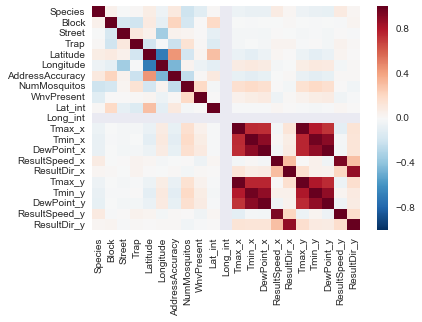

In [9]:
sns.heatmap(train.corr())
plt.figure(figsize=(10, 10))


In [10]:
y=train['WnvPresent']
X= train.drop(['WnvPresent'], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)

In [12]:
# rfc = ensemble.RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

# param_grid = { 
#     'n_estimators': [100,200,300,400,500],
#     'criterion': ["gini"],
#     'max_features': [None, 'sqrt', 'log2'],
#     'min_samples_split':[1,2,3,4,5,6]
# }

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)
# print CV_rfc.best_params_


In [13]:
#print CV_rfc.best_estimator_

In [14]:
# abc = ensemble.AdaBoostClassifier() 

# param_grid2 = { 
#     'n_estimators': [50,100,150,200],
#     'learning_rate': [1.0,2.0,3.0,4.0]
# }

# CV_abc= GridSearchCV(estimator=abc, param_grid=param_grid2, cv= 5)
# CV_abc.fit(X_train, y_train)
# print CV_abc.best_params_
# print CV_abc.best_estimator_

In [15]:
cv = KFold(len(y_train), shuffle=False) 
print cv
rf = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
rfScore = cross_val_score(rf, X_train, y_train, cv=cv,n_jobs=1)
print "Regular Decision Tree scores are:", rfScore
print "Regular Decision Tree average score is:", rfScore.mean()

sklearn.cross_validation.KFold(n=7354, n_folds=3, shuffle=False, random_state=None)
Regular Decision Tree scores are: [ 0.9408646   0.94451244  0.94655243]
Regular Decision Tree average score is: 0.943976490602


In [16]:
cv = KFold(len(y_train), shuffle=False) 
print cv
ab = ensemble.AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

abScore = cross_val_score(ab, X_train, y_train, cv=cv,n_jobs=1)
print "Adaboost Decision Tree scores are:", abScore
print "Adaboost Decision Tree average score is:", abScore.mean()

sklearn.cross_validation.KFold(n=7354, n_folds=3, shuffle=False, random_state=None)
Adaboost Decision Tree scores are: [ 0.94208809  0.94288046  0.94859241]
Adaboost Decision Tree average score is: 0.944520319857


In [17]:
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [18]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)

In [19]:
#averaginng feature importances across trees in random forest model
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ]),
 <a list of 8 Text yticklabel objects>)

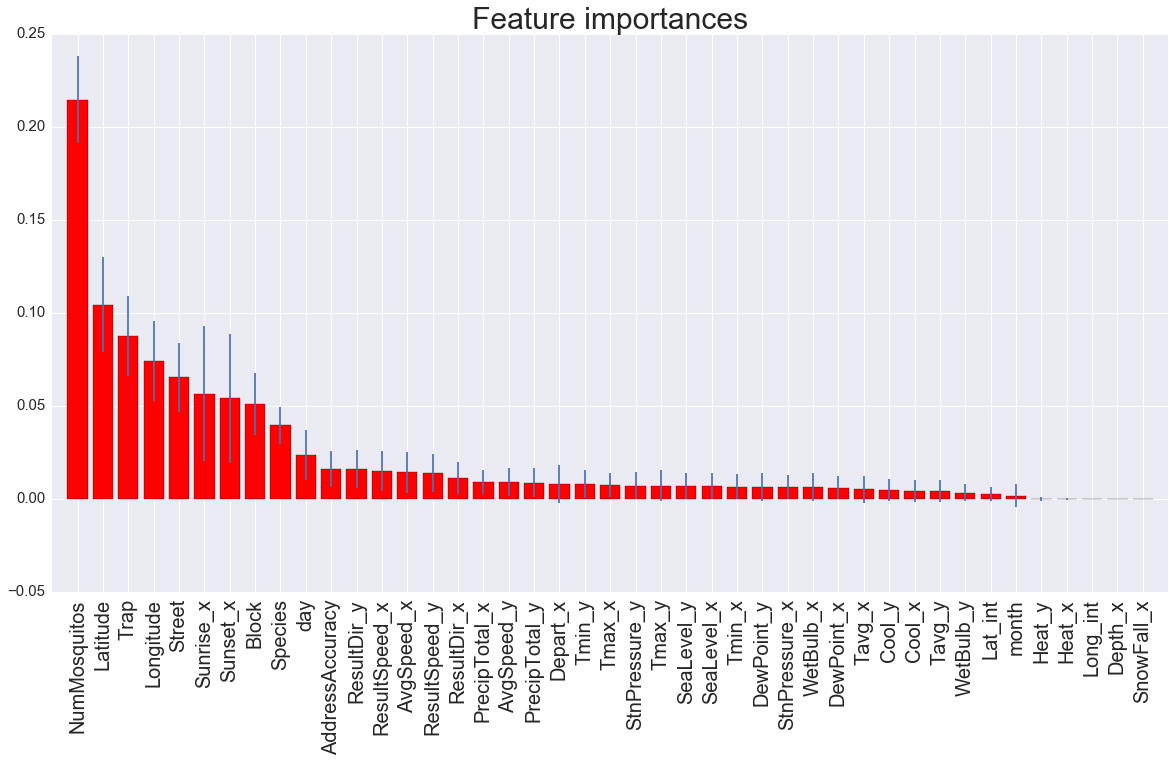

In [46]:
plt.figure(figsize=(20,10))
plt.title("Feature importances", fontsize = 30)
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90, fontsize = 20)
plt.xlim([-1, X_train.shape[1]])
plt.yticks(fontsize=15)

In [22]:
#random forest predictions
rfy_pred = rf.predict(X_test)
rfpredictions = pd.DataFrame()
rfpredictions['actual'] = y_test
rfpredictions['predict'] = rfy_pred
rfprobs = rf.predict_proba(X_test)
rfpredictions['ProbNeg'],rfpredictions['ProbPos'] = zip(*rfprobs)

In [23]:
pd.crosstab(rfpredictions['actual'], rfpredictions['predict'], rownames=['actual'])

predict,0,1
actual,,
0,2961,34
1,138,19


In [24]:
print 'precision score:',precision_score(rfpredictions['actual'],rfpredictions['predict'])
print 'recall score:',recall_score(rfpredictions['actual'],rfpredictions['predict'])
print 'accuracy score',accuracy_score(rfpredictions['actual'],rfpredictions['predict'])

precision score: 0.358490566038
recall score: 0.12101910828
accuracy score 0.945431472081


In [25]:
#Adaboost predictions
aby_pred = ab.predict(X_test)
abpredictions = pd.DataFrame()
abpredictions['actual'] = y_test
abpredictions['predict'] = aby_pred
abprobs = ab.predict_proba(X_test)
abpredictions['ProbNeg'],abpredictions['ProbPos'] = zip(*abprobs)

In [26]:
pd.crosstab(abpredictions['actual'], abpredictions['predict'], rownames=['actual'])

predict,0,1
actual,,
0,2974,21
1,144,13


In [27]:
print 'precision score:',precision_score(abpredictions['actual'],abpredictions['predict'])
print 'recall score:',recall_score(abpredictions['actual'],abpredictions['predict'])
print 'accuracy score',accuracy_score(abpredictions['actual'],abpredictions['predict'])

precision score: 0.382352941176
recall score: 0.0828025477707
accuracy score 0.947652284264


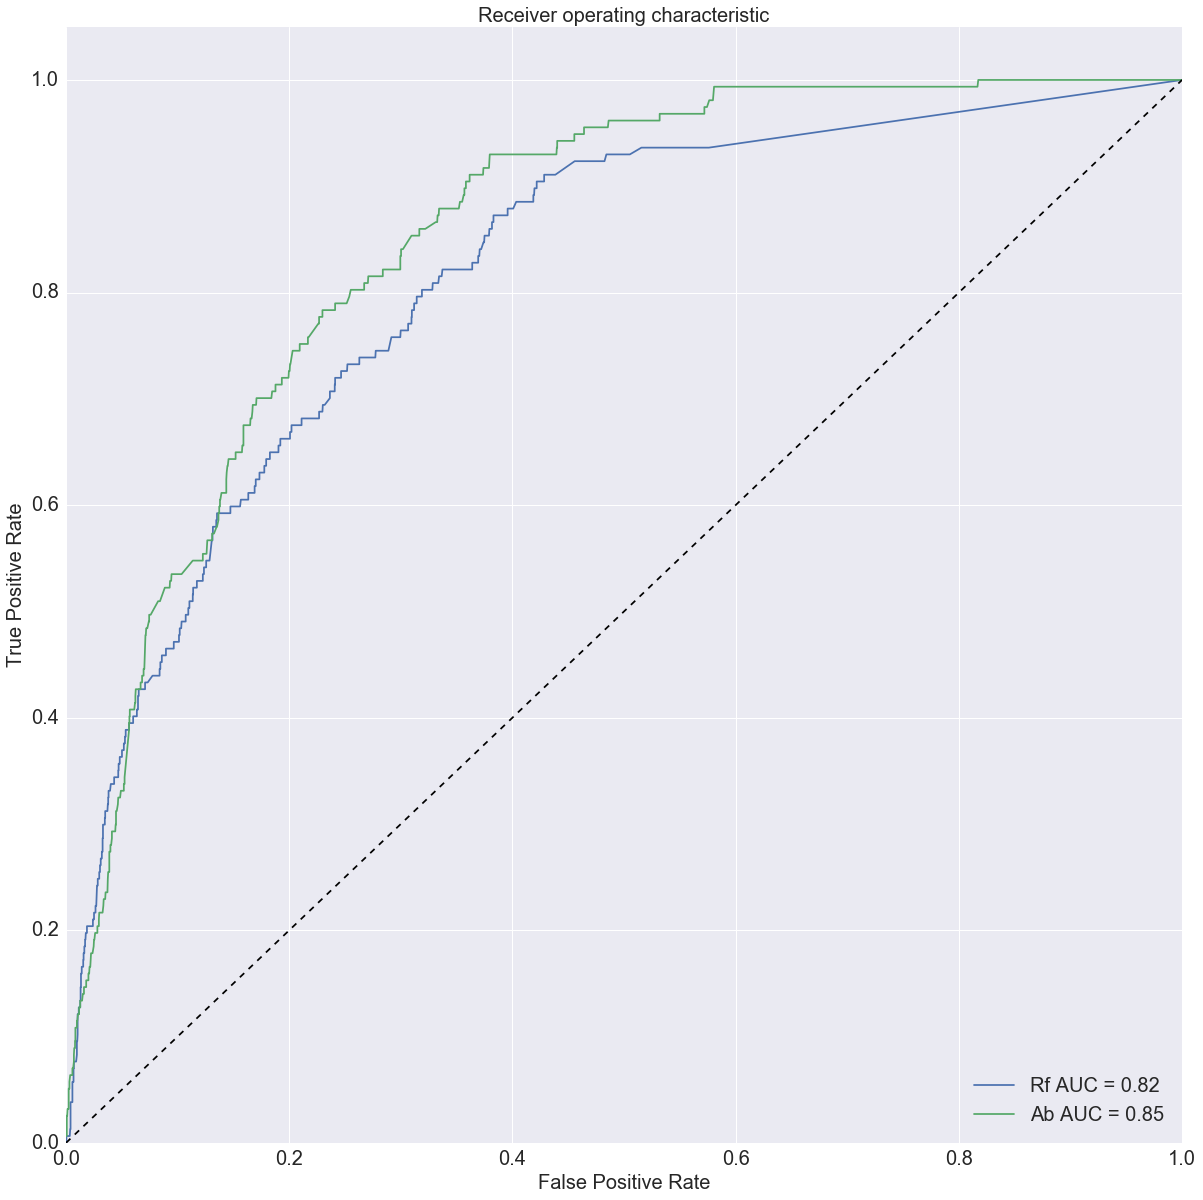

In [56]:
# Compute ROC curve and ROC area for Random Forest
rffpr = dict()
rftpr = dict()
rfroc_auc = dict()
rffpr, rftpr, _ = roc_curve(y_test, rfpredictions.ProbPos)
rfroc_auc = auc(rffpr, rftpr)

# Compute ROC curve and ROC area for Adaboost
abfpr = dict()
abtpr = dict()
abroc_auc = dict()
abfpr, abtpr, _ = roc_curve(y_test, abpredictions.ProbPos)
abroc_auc = auc(abfpr, abtpr)


# Plot of a ROC curve 
plt.figure(figsize=(20,20))
plt.plot(rffpr, rftpr, label='Rf AUC = %0.2f' % rfroc_auc)
plt.plot(abfpr, abtpr,label='Ab AUC = %0.2f' % abroc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

In [29]:
rfthreshold = 0.3
rfpredictions['threshPred'] = [0 if x < rfthreshold else 1 for x in rfpredictions['ProbPos']]

In [30]:
pd.crosstab(rfpredictions['actual'], rfpredictions['threshPred'], rownames=['actual'])

threshPred,0,1
actual,,
0,2881,114
1,106,51


In [31]:
print 'precision score:',precision_score(rfpredictions['actual'],rfpredictions['threshPred'])
print 'recall score:', recall_score(rfpredictions['actual'],rfpredictions['threshPred'])
print 'accuracy score:',accuracy_score(rfpredictions['actual'],rfpredictions['threshPred'])

precision score: 0.309090909091
recall score: 0.324840764331
accuracy score: 0.930203045685


In [39]:
abthreshold = 0.5
abpredictions['threshPred'] = [0 if x < abthreshold else 1 for x in abpredictions['ProbPos']]

In [40]:
pd.crosstab(abpredictions['actual'], abpredictions['threshPred'], rownames=['actual'])

threshPred,0,1
actual,,
0,2974,21
1,144,13


In [34]:
print 'precision score:',precision_score(abpredictions['actual'],abpredictions['threshPred'])
print 'recall score:', recall_score(abpredictions['actual'],abpredictions['threshPred'])
print 'accuracy score:',accuracy_score(abpredictions['actual'],abpredictions['threshPred'])

precision score: 0.382352941176
recall score: 0.0828025477707
accuracy score: 0.947652284264
